In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import hickle

from ase.io import read

import numpy as np

import torch
torch.set_default_dtype(torch.float64)

from mlelec.data.qmdataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, unfix_orbital_order
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
import metatensor.torch as mts
from metatensor.learn import DataLoader

import os
os.environ["PYSCFAD_BACKEND"] = "torch"
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol

import xitorch
from xitorch.linalg import symeig

from matplotlib import pyplot as plt

from IPython.utils import io as ipy_io

Using PyTorch backend.


/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
orbitals = {
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },
}

device = 'cpu'

In [4]:
max_radial  = 12
max_angular = 6
atomic_gaussian_width = 0.3
cutoff = 3.5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 4

# QMD

In [5]:
workdir = '../../my_mlelec/examples/data/water_1000'
every = 20

For the moment, we need to create multiple QMDataset (analogous to MoleculeDataset), one for the large basis, one for the small one.

In [6]:
qmdata = QMDataset.from_file(frames_path = f'{workdir}/water_1000.xyz', 
                             fock_realspace_path = f'{workdir}/def2svp/focks.npy', 
                             overlap_realspace_path = f'{workdir}/def2svp/overlaps.npy',
                             dimension = 0, 
                             device = 'cpu', 
                             orbs_name='def2svp', 
                             orbs=orbitals['def2svp'], 
                             frame_slice = f'::{every}')

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/qmdataset.py:169: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(item, dtype=torch.complex128 if any(isinstance(subitem, complex) for subitem in item) else torch.float64)


In [7]:
qmdata_sto3G = QMDataset.from_file(frames_path = f'{workdir}/water_1000.xyz', 
                         dimension = 0,
                         fock_realspace_path = f'{workdir}/sto-3g/fock.hickle',
                         overlap_realspace_path = f'{workdir}/sto-3g/overlap.hickle',
                         device = device, 
                         orbs = orbitals['sto-3g'], 
                         orbs_name = 'sto-3g',
                         frame_slice = f'::{every}'
                        )

In [8]:
qmdata_sto3G

QMDataset(
  device: cpu,
  basis_name: sto-3g,
  dimension: 0,
  nstructs: 50,
  kmesh: None,
  nao: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
  ncore: {1: 0, 5: 0, 6: 0, 7: 0, 8: 0},
  is_molecule: True,
  fock_realspace: True,
  fock_kspace: False,
  overlap_realspace: True,
  overlap_kspace: False
)

# MLD

In [9]:
from mlelec.data.mldataset import MLDataset
mldata = MLDataset(
                   # qmdata_sto3G, 
                   qmdata,
                   item_names = ['fock_blocks', 'fock_realspace', 'overlap_realspace', 'eigenvalues', 'atom_resolved_density', 'dipoles'],
                   # features = mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = LCUT,
                   train_frac = 0.5,
                   val_frac = 0.4,
                   test_frac = 0.1,
                   shuffle = False,
                   model_basis = orbitals['sto-3g'],
                   model_basis_name = 'sto-3g',
                   fix_p_orbital_order = True,
                   aux_overlap_realspace = qmdata_sto3G.overlap_realspace
                  )

cpu pair features
cpu single center features
cpu single center features


# Model

Initialize the model

In [10]:
from mlelec.models.equivariant_nonlinear_lightning import LitEquivariantNonlinearModel, MSELoss
from mlelec.models.equivariant_nonlinear_lightning import MLDatasetDataModule
from mlelec.callbacks.logging import LoggingCallback
from mlelec.callbacks.progress_bar import ProgressBar

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping

# Assuming you have `train_dataset`, `val_dataset`, and `test_dataset`
data_module = MLDatasetDataModule(mldata, batch_size=16)

# Initialize with custom loss function and keyword arguments for derived predictions

model = LitEquivariantNonlinearModel(
    mldata=mldata,
    nhidden=4,
    nlayers=1,
    activation='SiLU',
    apply_norm=True,
    optimizer =  'adam',
    learning_rate=1e-3,
    lr_scheduler_patience=20,
    lr_scheduler_factor=0.8,
    lr_scheduler_min_lr=1e-6,
    loss_fn=MSELoss(),
    is_indirect = True,
    adaptive_loss_weights=False,
    # target_properties = {'eigenvalues', 'atom_resolved_density', 'dipoles'}
    target_properties = {'dipoles'}
    # eigenvalues = True,
    # atom_resolved_density = True
)

In [11]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"

In [12]:
logger = TensorBoardLogger("tb_logs", name="water")

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=100,
    verbose=False,
    mode='min'
)

In [14]:
progress_bar = ProgressBar()
logger_callback = LoggingCallback(log_every_n_epochs = 5)

In [15]:
trainer = pl.Trainer(max_epochs=10000, 
                     accelerator='cpu', 
                     # logger = logger, 
                     # log_every_n_steps = 1, 
                     check_val_every_n_epoch=10,
                     # callbacks=[early_stopping, progress_bar]
                     callbacks=[early_stopping, logger_callback],
                     # enable_progress_bar=False
                     # accelerator = 'gpu'
                    )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [16]:
trainer.fit(model, data_module)

/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:316: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | EquivariantNonlinearModel | 126 K  | train
------------------------------------------------------------
126 K     Trainable params
0         Non-trainable params
126 K     Total params
0.507     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dat

Training: |                                                                                                   …

/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1, Train Loss: 520.6855236197986
Epoch 5, Train Loss: 91.95004221401406


Validation: |                                                                                                 …

Epoch 10, Train Loss: 66.36944629454091, Validation Loss: 71.43152142565195, RMSE Eigenvalues: None, RMSE ARD: None, , RMSE Dipoles: 1.2951482157948546
Epoch 15, Train Loss: 56.29549839421987


Validation: |                                                                                                 …

Epoch 20, Train Loss: 52.52138991744057, Validation Loss: 60.139317771028836, RMSE Eigenvalues: None, RMSE ARD: None, , RMSE Dipoles: 1.1747643826232916
Epoch 25, Train Loss: 49.663009325453075


Validation: |                                                                                                 …

Epoch 30, Train Loss: 46.25959647669535, Validation Loss: 52.17967807010791, RMSE Eigenvalues: None, RMSE ARD: None, , RMSE Dipoles: 1.0925700001629661



Detected KeyboardInterrupt, attempting graceful shutdown ...
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/pyscf_calculator.py:493: SyntaxWarning: invalid escape sequence '\s'
  """Combine each relative translation vector with the corresponding phase difference to obtain the kpoint matrix. H(K) = \sum_R e^{ik.R} H(R)}
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/pyscf_calculator.py:521: SyntaxWarning: invalid escape sequence '\s'
  """

KeyboardInterrupt



In [ ]:
H=qmdata.fock_realspace[0]
S=qmdata.overlap_realspace[0]
symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S))

In [639]:
def _ard(frame, C, nelec, basis, S = None):
    split_idx = [len(basis[s]) for s in frame.numbers]
    needed = len(np.unique(split_idx)) > 1
    max_dim = np.max(split_idx)

    occ = torch.tensor([2 if i < nelec // 2 else 0 for i in range(C.shape[-1])]).to(dtype = C.dtype)
    rho = torch.einsum('n,...in,...jn->ij...', occ, C, C.conj())
    if S is not None:
        rho = rho@S

    slices = torch.split(rho, split_idx, dim=0)
    blocks = [torch.split(slice_, split_idx, dim=1) for slice_ in slices]
    blocks_flat = [block for sublist in blocks for block in sublist]

    if needed:
        squared_blocks = []
        for block in blocks_flat:
            pad_size = (0, max_dim - block.size(1), 0, max_dim - block.size(0))
            squared_block = torch.nn.functional.pad(block, pad_size, "constant", 0)
            squared_blocks.append(squared_block)
        blocks_flat = squared_blocks

    return torch.einsum('i...->...i', (torch.stack(blocks_flat)**2).sum(dim=(1,2))), blocks_flat
    # return torch.einsum('i...->...i', torch.stack(blocks_flat).norm(dim=(1,2))), blocks_flat

In [230]:
def naive_MayerBond(blocks):
    natm = np.sqrt(len(blocks))
    assert int(natm)-natm==0
    natm = int(natm)
    MB = np.zeros((natm,natm))
    ii = 0
    for i in range(natm):
        for j in range(natm):
            b = blocks[ii]
            for s in range(b.shape[0]):
                for t in range(b.shape[1]):
                    MB[i,j] += b[s,t]*b[s,t]
            ii += 1
    return MB

In [193]:
ds = qmdata#_sto3G

frame = ds.structures[0]
ncore = sum(ds.ncore[s] for s in frame.numbers)
nelec = sum(frame.numbers) - ncore 
H = ds.fock_realspace[0].numpy()
S = ds.overlap_realspace[0].numpy()

from scipy.linalg import eigh
e, C = eigh(H,S)
E = np.diag(e)
assert np.linalg.norm(H@C-S@C@E) < 1e-12

occ = np.zeros_like(e)
occ[:nelec//2] = 2
rho = np.einsum('m,im,jm->ij',occ,C,C.conj())

print(np.trace(rho), np.trace(rho@S))

6.873148718119957 10.000000000000009


(24, 24)

In [18]:
trainer.test(model, data_module)

/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

/home/nigam/miniconda3/envs/py312/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       rmse_dipoles        │     7.887536799630146     │
│         test_loss         │     933.1985514827963     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 933.1985514827963, 'rmse_dipoles': 7.887536799630146}]

In [138]:
from mlelec.data.derived_properties import compute_atom_resolved_density, compute_eigenvalues

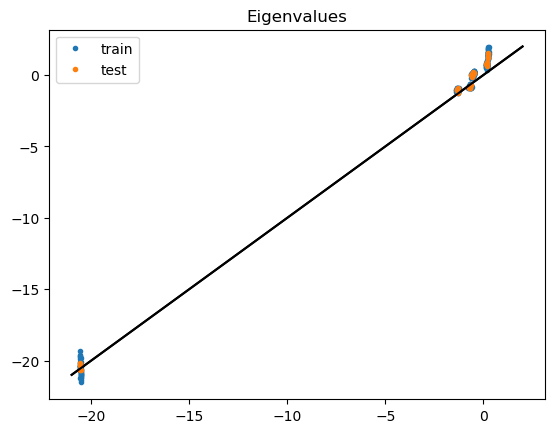

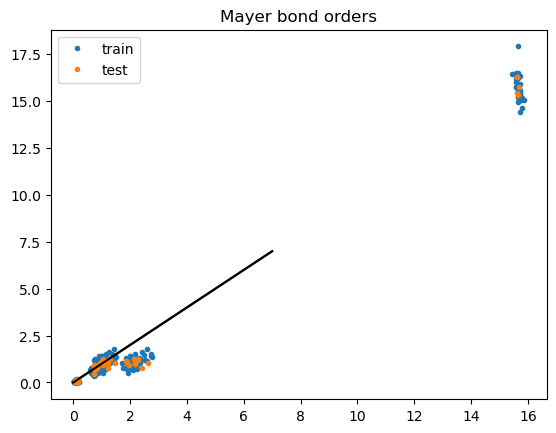

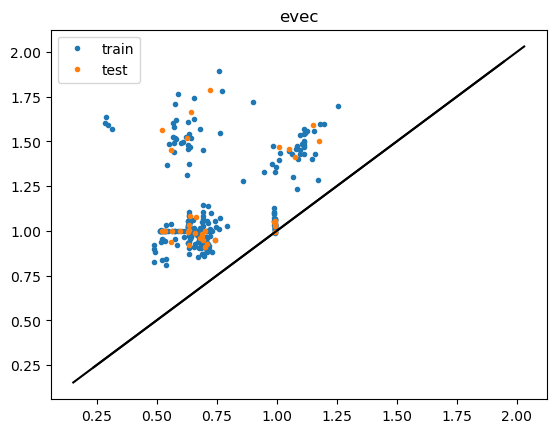

In [681]:
test_dl = DataLoader(mldata.test_dataset, batch_size = len(mldata.test_dataset), collate_fn=mldata.group_and_join)
train_dl = DataLoader(mldata.train_dataset, batch_size = len(mldata.train_dataset), collate_fn=mldata.group_and_join)

test_dl_frames_dict = {A.item(): f for A, f in zip(mldata.test_idx, mldata.test_frames)}
train_dl_frames_dict = {A.item(): f for A, f in zip(mldata.train_idx, mldata.train_frames)}

fig_e, ax_e = plt.subplots()
fig_a, ax_a = plt.subplots()
fig_evec, ax_evec = plt.subplots()

data = {}
for dl_, frames_dict, lbl in zip([train_dl, test_dl], [train_dl_frames_dict, test_dl_frames_dict], ['train', 'test']):
    batch = next(iter(dl_))
    pred = model(batch.features, mldata.model_metadata)

    
    HT = blocks_to_matrix(pred, mldata.model_basis, frames_dict, detach = True)
    HT = [h[0,0,0] for h in HT]

    pred_eigvals, pred_eigvec = compute_eigenvalues(HT, batch.overlap_realspace, return_eigenvectors=True)
    pred_ard, _ = compute_atom_resolved_density(pred_eigvec, 
                                                [mldata.qmdata.structures[i] for i in batch.sample_id], 
                                                 mldata.model_basis, 
                                                 mldata.qmdata.ncore)
    # pred_eigvals, pred_ard, pred_eigvec, pred_rho = compute_ard_vec(qmdata, batch, HT, device, overlap = [qmdata.overlap_realspace[i] for i in batch.sample_id])

    small_shapes = [p.shape for p in pred_eigvals]
    slices = [tuple(slice(0, dim) for dim in small_shape) for small_shape in small_shapes]
    x = torch.cat([batch.eigenvalues[i][s].flatten() for i, s in enumerate(slices)])
    y = torch.cat([p.flatten() for p in pred_eigvals])
    ax_e.plot(x, y, '.', label = lbl)
    ax_e.plot([-21, 2], [-21, 2], 'k')
    ax_e.set_title('Eigenvalues')
    ax_e.legend()

    x = torch.cat([ard.flatten() for ard in batch.atom_resolved_density])
    y = torch.cat([ard.flatten() for ard in pred_ard])
    ax_a.plot(x, y, '.', label = lbl)
    ax_a.plot([0,7], [0,7], 'k')
    ax_a.set_title('Mayer bond orders')
    ax_a.legend()

    small_shapes = [p.shape for p in pred_eigvec]
    slices = [tuple(slice(0, dim) for dim in small_shape) for small_shape in small_shapes]
    x = torch.cat([torch.norm(batch.eigenvectors[i][s], dim = (0)).flatten() for i, s in enumerate(slices)])
    y = torch.cat([torch.norm(p, dim = (0)).flatten() for p in pred_eigvec])
    # pred_evn, targ_evn = torch.norm(pred_eigvec, dim = (1)), torch.norm(batch.eigenvectors[slices], dim = (1))
    
    ax_evec.plot(x, y, '.', label = lbl)
    xmin, xmax = ax_evec.get_xlim()
    ymin, ymax = ax_evec.get_ylim()
    xmin = np.min([xmin,ymin])
    xmax = np.max([xmax,ymax])
    ax_evec.plot([xmin,xmax], [xmin,xmax], 'k')
    ax_evec.set_title('evec')
    ax_evec.legend()

In [98]:
def compute_dipole_moment(frames, fock_predictions, overlaps, basis = 'sto-3g'):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame, basis = basis)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [99]:
batch = next(iter(test_dl))
print(batch.sample_id)

dl_frames = [qmdata.structures[A] for A in batch.sample_id]
dl_frames_dict = {A: f for A, f in zip(batch.sample_id, dl_frames)}
pred = model(batch.features, mldata.model_metadata)

HT = blocks_to_matrix(pred, mldata.model_basis, dl_frames_dict, detach = True)
HT = [h[0,0,0] for h in HT]

# Predictions need fixing/unfixing the orbital order
fock_predictions = unfix_orbital_order(
    torch.stack(HT),
    dl_frames,
    qmdata_sto3G.basis
)
over_predictions = unfix_orbital_order(
    batch.overlap_realspace,
    dl_frames,
    qmdata_sto3G.basis
)

# QMDataset does NOT need fixing/unfixing the orbital order
fock_targets = torch.stack([qmdata.fock_realspace[i] for i in batch.sample_id])
over_targets = torch.stack([qmdata.overlap_realspace[i] for i in batch.sample_id])

fock_sto3g = torch.stack([qmdata_sto3G.fock_realspace[i] for i in batch.sample_id])
over_sto3g = torch.stack([qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id])

with ipy_io.capture_output():
    dipole_targets = compute_dipole_moment(
        dl_frames,
        fock_targets,
        over_targets,
        qmdata.basis_name)

with ipy_io.capture_output():
    dipole_predictions = compute_dipole_moment(
        dl_frames,
        fock_predictions,
        over_predictions,
        qmdata_sto3G.basis_name)

with ipy_io.capture_output():
    dipole_sto3g = compute_dipole_moment(
        dl_frames,
        fock_sto3g,
        over_sto3g,
        qmdata_sto3G.basis_name)

(180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199)


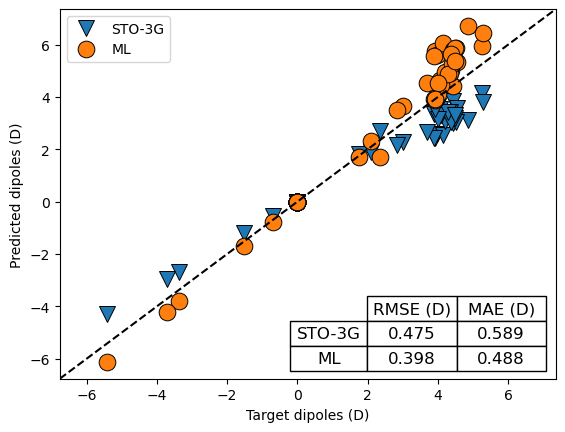

In [123]:
from ase.units import Bohr, Debye
au_to_debye = Bohr/Debye

ms = 12
mew = .7

fig, ax = plt.subplots()

x = dipole_targets.flatten().detach().cpu() * au_to_debye
y_sto3g = dipole_sto3g.flatten().detach().cpu() * au_to_debye
y_ml = dipole_predictions.flatten().detach().cpu() * au_to_debye

rmse_sto3g = np.sqrt(torch.mean(y_sto3g - x)**2)
rmse_ml = np.sqrt(torch.mean(y_ml - x)**2)
mae_sto3g = torch.mean(torch.abs(y_sto3g - x))
mae_ml = torch.mean(torch.abs(y_ml - x))

ax.plot(x, y_sto3g, 'v', 
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'STO-3G', 
         alpha = 1)

ax.plot(x, y_ml, 'o',
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'ML', 
         alpha = 1)

ax.legend()

xm, xM = ax.get_xlim()
ym, yM = ax.get_ylim()
m = np.min([xm,ym])
M = np.max([xM,yM])
ax.plot([m,M], [m,M], '--k')
ax.set_xlim(m, M)
ax.set_ylim(m, M)

# ax.text(0.6, 0.3, fr'$\mathrm{{RMSE_{{\text{{STO-3G}}}}}}={rmse_sto3g:.3f}\,$D', transform = ax.transAxes, ha = 'left')
# ax.text(0.6, 0.25, fr'$\mathrm{{RMSE_{{ML}}}}={rmse_ml:.3f}\,$D', transform = ax.transAxes, ha = 'left')

ax.set_xlabel('Target dipoles (D)')
ax.set_ylabel('Predicted dipoles (D)')

# Adding a table with RMSE and MAE for STO-3G and ML
table_data = [
    [f'{rmse_sto3g:.3f}', f'{mae_sto3g:.3f}'],
    [f'{rmse_ml:.3f}', f'{mae_ml:.3f}']
]
# table = ax.table(cellText=table_data, colLabels=['RMSE', 'MAE'], rowLabels=['STO-3G', 'ML'],
#                  edges = 'closed',
#                  loc='bottom', cellLoc = 'center', rowLoc = 'center', colWidths = [0.3, 0.3])

# Create the table inside the plot area
table = ax.table(cellText=table_data, colLabels=['RMSE (D)', 'MAE (D)'], rowLabels=['STO-3G', 'ML'],
                 loc='lower right', cellLoc = 'center', rowLoc = 'center', colWidths = [0.12, 0.12])

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

# ax.set_title('Indirect training from def2-svp to a STO-3G-like model.\nTargets: eigenvalues; ARD; eigenvector norms over AOs\nTest set contains 50 water molecules')